In [13]:
import math

import hist

import pylhe

import numpy as np

import matplotlib.pyplot as plt

from scipy.integrate import quad

In [14]:
lhe_file = '/home/jwdiao/online_2/Events/run_01/unweighted_events.lhe'
events = pylhe.to_awkward(pylhe.read_lhe_with_attributes(lhe_file))
print(events.particles.fields)

['vector', 'id', 'status', 'mother1', 'mother2', 'color1', 'color2', 'm', 'lifetime', 'spin']


In [15]:
def momentum_array(event):
            px = event.px
            py = event.py
            pz = event.pz
            p = pylhe.awkward.ak.zip({"px":px, "py":py, "pz":pz})
            return p

def dot_product(p1, p2): #particle array 1 and 2
            p1p = momentum_array(p1)
            p2p = momentum_array(p2)
            return (p1p["px"] * p2p["px"] + p1p["py"] * p2p["py"] + p1p["pz"] * p2p["pz"])

def momentum_mag(particle):
            return np.sqrt(particle.px**2 + particle.py**2 + particle.pz**2)

def calculate_cos(p1, p2):
            dot = dot_product(p1,p2)
            cos_theta = dot/ (momentum_mag(p1) * momentum_mag(p2))
            return cos_theta

In [16]:
pevents = events.particles

In [ ]:
products = pevents[:,2:]
print(products.id)
def calculate_yn(products):
    decay_1_events = products[products.id==11]
    decay_2_events = products[products.id==24]
    e = decay_1_events.vector.e + decay_2_events.vector.e
    px = decay_1_events.vector.x + decay_2_events.vector.x
    py = decay_1_events.vector.y + decay_2_events.vector.y
    pz = decay_1_events.vector.z + decay_2_events.vector.z
    p = np.sqrt(px**2 + py**2 + pz**2)

    m_sq = e**2 - p**2
    m_t = np.sqrt(m_sq + px**2 + py**2)
    y = np.arcsinh(pz / m_t)
    return(y)

# use this when we have no decay of N
def calculate_yn_2(pevents):
    nevents = pevents[pevents.id==9990012] #M 9900012 old 9000005 D 9990012, change the ID of the SN according to model we are using. 
                                            #Use the first one for Majorana model, second for the old model, and third for Dirac model
    e = nevents.vector.e
    px = nevents.vector.x
    py = nevents.vector.y
    pz = nevents.vector.z
    p = np.sqrt(px**2 + py**2 + pz**2)
    m_sq = e**2 - p**2
    m_t = np.sqrt(m_sq + px**2 + py**2)
    y = np.arcsinh(pz / m_t)
    return(y)
print(pevents[:,3].m)
y = calculate_yn(products)
print(len(y))
print()

def calculate_mass(products):
    decay_1_events = products[products.id==11]
    decay_2_events = products[products.id==24]
    e = decay_1_events.vector.e + decay_2_events.vector.e
    px = decay_1_events.vector.x + decay_2_events.vector.x
    py = decay_1_events.vector.y + decay_2_events.vector.y
    pz = decay_1_events.vector.z + decay_2_events.vector.z
    p = np.sqrt(px**2 + py**2 + pz**2)
    m =  np.sqrt(e**2 - p**2)
    return(m)

def calculate_mass_single(particle_info):
    p = np.sqrt(particle_info.vector.x ** 2 + particle_info.vector.y ** 2 + particle_info.vector.z ** 2)
    m = np.sqrt(p**2 - particle_info.vector.e**2)
    return(m)

[[-24, 11, 24, -12], [-24, 11, 24, -12], ..., [11, ...], [-24, 11, 24, -12]]
[0, 0, 0, 0, 80, 0, 0, 0, 80, 0, 0, 80, ..., 0, 0, 0, 0, 80, 0, 0, 0, 0, 80, 0]
100000



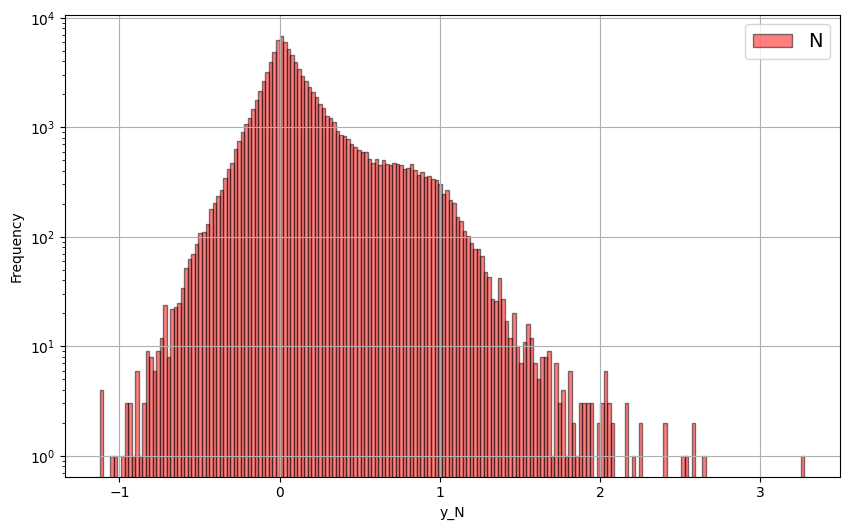

100000


In [18]:
# plotting the yN distribution
plt.figure(figsize=(10, 6))
plt.hist(y, bins=200, alpha=0.5, label='N', edgecolor= "black",color='red')
plt.xlabel('y_N')
plt.ylabel('Frequency')
#plt.title('Rapidity Distributions for Sterile Neutrinos and Anti-Sterile Neutrinos (Majorana)')
plt.legend(fontsize=14)
plt.grid()
plt.yscale("log")
plt.show()
print(len(y))

calculated sigma 1.2156426356291678e-07
real sigma 6.677294e-07
location of peak 1.0986122886681098
min of y -0.03527555665758451


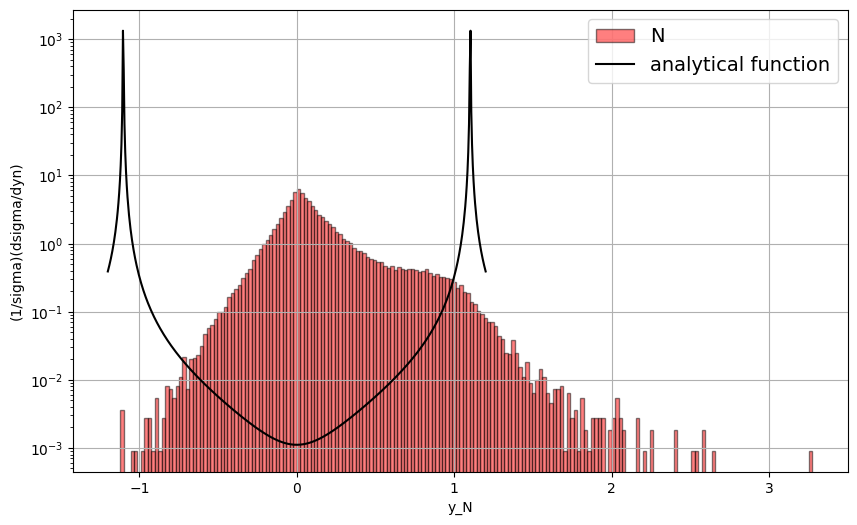

In [19]:
# fitting the analytic function with the yN distribution

s = 3000**2
m_N = 1000
m_W = 79.8
g = 0.648397
u = 1
r_sigma = 260 * 2.56819*(10**-9)

def dsigma_dyn(yn, s, m_N, m_W, g):
    numerator = g**4 *(s + m_N**2)**2*np.exp(4*yn)*(s*np.exp(2*yn)-m_N**2)
    denominator = 16*np.pi*s**2*(s+m_W**2+(m_W**2-m_N**2)*np.exp(2*yn))**2*(np.exp(2*yn)+1)**2
    return 2 * (1/np.sqrt(2))**4 * numerator / denominator

def dsigma_dcos(cos, s, m_N, m_W, g):
            numerator = g**4*(1 + cos)*(s - m_N**2)**2 * (s + m_N**2 + cos * (s - m_N**2))
            denominator = 64 * np.pi * s**2 * ((s - m_N**2) * (1 - cos) + 2 * m_W**2)**2
            return 2 * (1/np.sqrt(2))**4 * numerator / denominator

sigma, _ = quad(dsigma_dcos, -1, 1, args=(s, m_N, m_W, g))
print("calculated sigma", sigma)
yn_values = np.linspace(-1.2, 1.2, 500)
y_values = u * (dsigma_dyn(yn_values, s, m_N, m_W, g) + dsigma_dyn(-yn_values, s, m_N, m_W, g))
steps =  200
print("real sigma", r_sigma)
yrange = 1/2 * np.log(s/m_N**2)
print("location of peak", yrange)
print("min of y", min(y[0]))
l_factor = r_sigma / ((yrange*2/steps)*len(y))
plt.figure(figsize=(10, 6))
plt.hist(y, bins=int(steps), weights=np.ones_like(y) * l_factor/r_sigma,alpha=0.5, label='N', edgecolor= "black",color='red')
plt.plot(yn_values, y_values/sigma, label='analytical function', color='black')
plt.xlabel('y_N')
plt.ylabel('(1/sigma)(dsigma/dyn)')
#plt.title('Rapidity Distributions for Sterile Neutrinos and Anti-Sterile Neutrinos (Majorana)')
plt.legend(fontsize=14)
plt.grid()
plt.yscale("log")
plt.show()

In [ ]:

def calculate_mass_single(particle_info):
    p_sqr = particle_info.vector.x ** 2 + particle_info.vector.y ** 2 + particle_info.vector.z ** 2
    m = particle_info.vector.e**2 - p_sqr
    return(m)

def calculate_mass_w(products):
    decay_1_events_n = products[products.id==-12]
    decay_1_events_p = products[products.id== 12]
    decay_1_events = pylhe.awkward.ak.concatenate([decay_1_events_n, decay_1_events_p], axis=1)
    decay_2_events = products[products.id==11]
    e = decay_1_events.vector.e + decay_2_events.vector.e
    px = decay_1_events.vector.x + decay_2_events.vector.x
    py = decay_1_events.vector.y + decay_2_events.vector.y
    pz = decay_1_events.vector.z + decay_2_events.vector.z
    p = np.sqrt(px**2 + py**2 + pz**2)
    m =  np.sqrt(e**2 - p**2)
    return(m)

In [21]:
import pylhe.awkward


# off_shell_events = products[pylhe.awkward.ak.num(products.id) == 3]
# on_shell_events = products[pylhe.awkward.ak.num(products.id) == 4]

# y_off = calculate_yn(off_shell_events)
# y_on = calculate_yn(on_shell_events)
# neutrino_m = calculate_mass_single(off_shell_events[off_shell_events.id == -12])
# print(max(neutrino_m))
# print(neutrino_m > 400)
# electron_m = calculate_mass_single(off_shell_events[off_shell_events.id == 11])
# w_m = calculate_mass_single(off_shell_events[off_shell_events.id == 24])
# y_off = y_off[w_m - neutrino_m - electron_m > 400]
# # print(min(neutrino_m))
# print(neutrino_m[neutrino_m < 0])
w_m = calculate_mass_w(products)


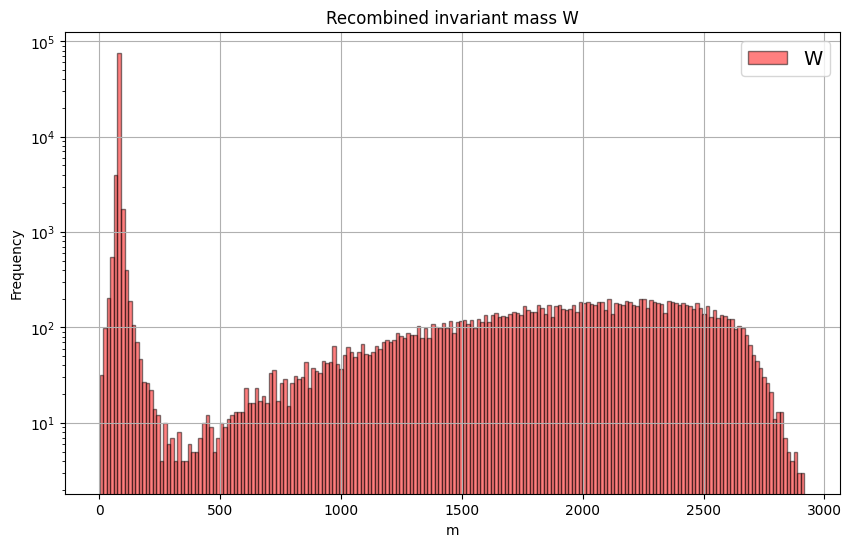

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(w_m, bins=200, alpha=0.5, label='W', edgecolor= "black",color='red')
plt.xlabel('m')
plt.ylabel('Frequency')
plt.title('Recombined invariant mass W')
plt.legend(fontsize=14)
plt.grid()
plt.yscale("log")
plt.show()

In [23]:
#plotting off-shell distribution of yn 
# plt.figure(figsize=(10, 6))
# plt.hist(y_off, bins=200, alpha=0.5, label='N', edgecolor= "black",color='red')
# plt.xlabel('y_N')
# plt.ylabel('Frequency')
# plt.title('Rapidity Distributions for the process (3 decay products)')
# plt.legend(fontsize=14)
# plt.grid()
# plt.yscale("log")
# plt.show()

In [24]:
# if len(y_off) != 0:
#     # l_factor = sigma / (len(y_off) * 2/steps)
#     plt.figure(figsize=(10, 6))
#     plt.hist(y_off, bins=int(steps), weights=np.ones_like(y_off) * l_factor/r_sigma,alpha=0.5, label='N', edgecolor= "black",color='red')
#     # plt.plot(yn_values, y_values/sigma, label='analytical function', color='black')
#     plt.xlabel('y_N')
#     plt.ylabel('1/sigma dsigma/dyn')
#     #plt.title('Rapidity Distributions for Sterile Neutrinos and Anti-Sterile Neutrinos (Majorana)')
#     plt.legend(fontsize=14)
#     plt.grid()
#     plt.yscale("log")
#     plt.show()

In [25]:
# # onshell yn
# plt.figure(figsize=(10, 6))
# plt.hist(y_on, bins=200, alpha=0.5, label='N', edgecolor= "black",color='red')
# plt.xlabel('y_N')
# plt.ylabel('Frequency')
# plt.title('Rapidity Distributions for the other process')
# plt.legend(fontsize=14)
# plt.grid()
# plt.yscale("log")
# plt.show()

100000


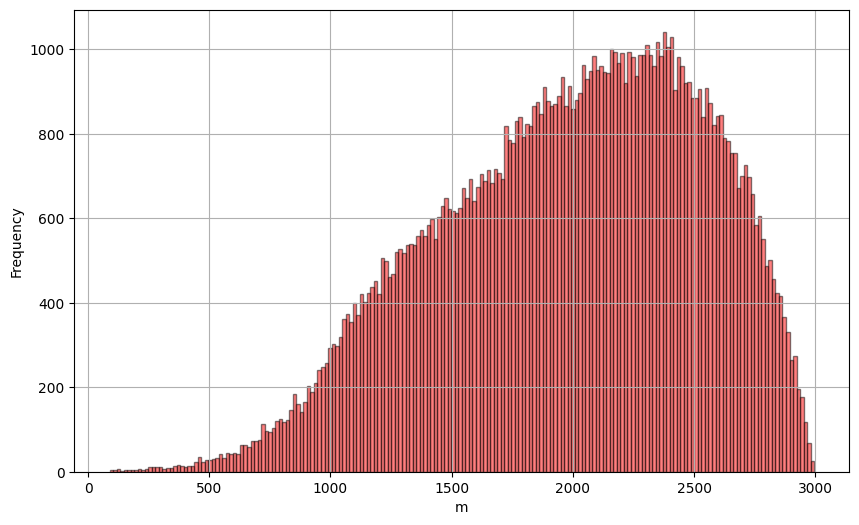

100000

In [26]:
# invariant mass distribution
m = calculate_mass(products)
print(len(m))
plt.figure(figsize=(10, 6))
plt.hist(m, bins=200, alpha=0.5, label='N', edgecolor= "black",color='red')
plt.xlabel('m')
plt.ylabel('Frequency')
#plt.title('Rapidity Distributions for Sterile Neutrinos and Anti-Sterile Neutrinos (Majorana)')
#plt.legend(fontsize=14)
plt.grid()
#plt.yscale("log")
plt.show()
len(m)

[[-0.0353], [-0.0361], [-0.0214], [-0.1], ..., [0.00842], [0.24], [1.1], [0.26]]
100000


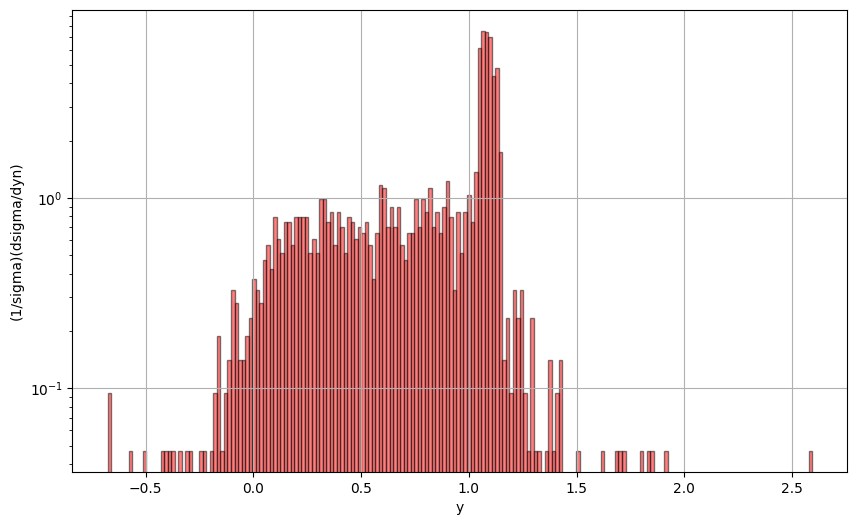

1938


In [38]:
# filtering yn around the peak
print(y)
layer_1 = y[np.abs(m_W - w_m) > 20]
#l1 = layer_1[pylhe.awkward.ak.num(layer_1) > 0]
masked = layer_1[np.abs(m-m_N) < m_N * 0.05]
filtered_array = masked[pylhe.awkward.ak.num(masked) > 0]
print(len(masked))
len(filtered_array)
step = 200
# r_sigma = 38.63 * 2.56819*(10**-9)
l_factor = r_sigma / ((yrange*2/steps)*len(filtered_array))
plt.figure(figsize=(10, 6))
plt.hist(filtered_array, bins=step,weights=np.ones_like(filtered_array) * l_factor/r_sigma, alpha=0.5, label='N', edgecolor= "black",color='red')
plt.xlabel('y')
plt.ylabel('(1/sigma)(dsigma/dyn)')
plt.grid()
plt.yscale("log")
plt.show()
print(len(filtered_array))

In [ ]:
m_N = 2500
p = np.sqrt((s-(m_N + m_W)**2)*(s-(m_N - m_W)**2))/(2*np.sqrt(s))
e = np.sqrt(m_N**2 + p**2)
np.arctanh(p/e)

0.1799908459428646

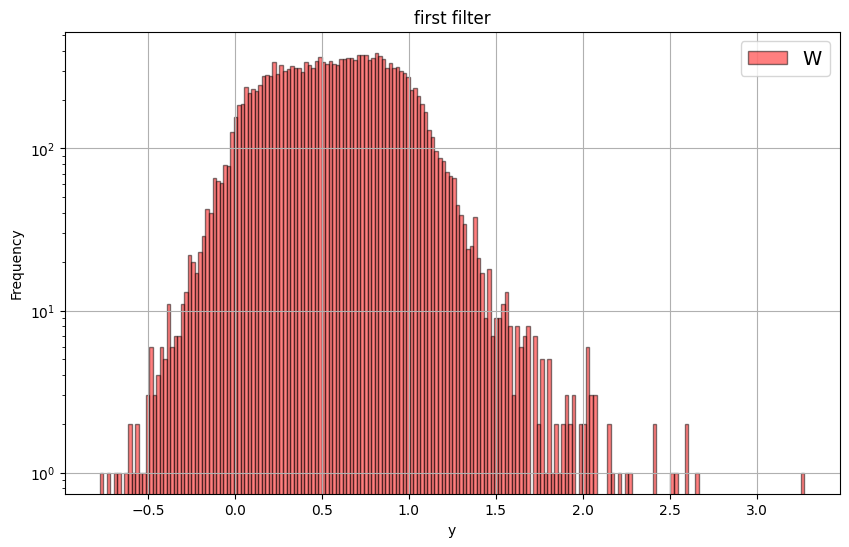

In [41]:
l1 = layer_1[pylhe.awkward.ak.num(layer_1) > 0]
plt.figure(figsize=(10, 6))
plt.hist(l1, bins=200, alpha=0.5, label='W', edgecolor= "black",color='red')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.title('first filter')
plt.legend(fontsize=14)
plt.grid()
plt.yscale("log")
plt.show()

In [ ]:
s = 3000**2
m_N = 1000
m_W = 79.8
g = 0.664
u = 1

def dsigma_dyn(yn, s, m_N, m_W, g):
    numerator = g**4 *(s + m_N**2)**2*np.exp(4*yn)*(s*np.exp(2*yn)-m_N**2)
    denominator = 16*np.pi*s**2*(s+m_W**2+(m_W**2-m_N**2)*np.exp(2*yn))**2*(np.exp(2*yn)+1)**2
    return numerator / denominator


def dsigma_dcos(cos, s, m_N, m_W, g):
            numerator = g**4*(1 + cos)*(s - m_N**2)**2 * (s + m_N**2 + cos * (s - m_N**2))
            denominator = 64 * np.pi * s**2 * ((s - m_N**2) * (1 - cos) + 2 * m_W**2)**2
            return numerator / denominator
sigma1a, _ = quad(dsigma_dcos, -1, 1, args=(s, m_N, m_W, g))
sigma2a, _ = quad(dsigma_dyn, -1.09861, 1.09861, args=(s, m_N, m_W, g))
sigma1b, _ = quad(dsigma_dcos, -1, 1, args=(s, 2500, m_W, g))
sigma2b, _ = quad(dsigma_dyn, -0.18, 0.18, args=(s, 2500, m_W, g))
sigmat1, _ = quad(dsigma_dyn, -0.181, 0.181, args=(s, 2500, m_W, g))
sigmat2, _ = quad(dsigma_dyn, -0.182, 0.182, args=(s, 2500, m_W, g))
sigmat3, _ = quad(dsigma_dyn, -0.183, 0.183, args=(s, 2500, m_W, g))
print(sigma1a, sigma2a)
print(sigma1b, sigma2b)
print(sigma1b/sigma1a)
print(sigma2b/sigma2a)
print(1.873*10**6/(3.567*10**5))
print(sigmat1, sigmat2, sigmat3)


2.6738943861850244e-07 2.672150677460068e-07
9.120727586356347e-08 2.3728573919770826e-08
0.34110276133117334
0.08879953559477158
5.250911129800953
3.517057964000382e-08 6.603767214375614e-08 4.3226493437712065e-07


[[0.148], [0.701], [0.181], [0.271], ..., [0.159], [0.035], [0.597], [0.334]]


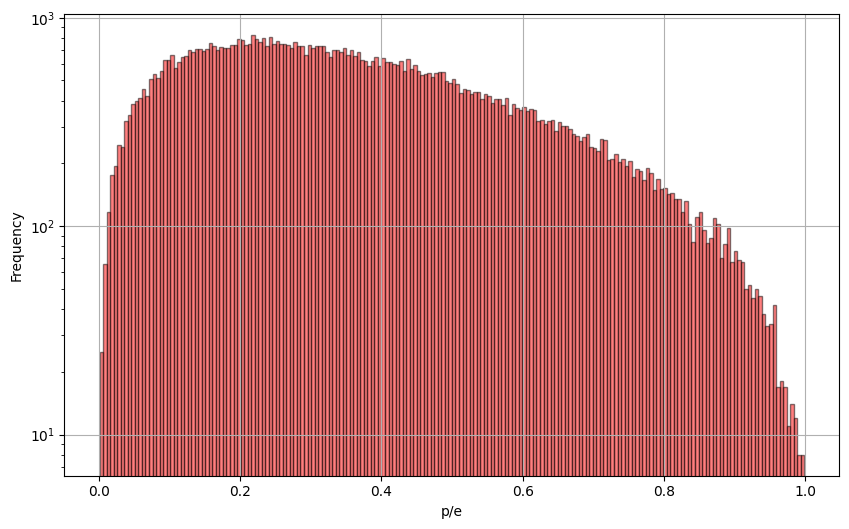

In [ ]:
#p/e distribution
decay_1_events = on_shell_events[on_shell_events.id==11]
decay_2_events = on_shell_events[on_shell_events.id==24]
e = decay_1_events.vector.e + decay_2_events.vector.e
px = decay_1_events.vector.x + decay_2_events.vector.x
py = decay_1_events.vector.y + decay_2_events.vector.y
pz = decay_1_events.vector.z + decay_2_events.vector.z
p = np.sqrt(px**2 + py**2 + pz**2)
m_prime =  np.sqrt(e**2 - p**2)
y = np.arctanh(p/e)
print(p/e)
plt.figure(figsize=(10, 6))
plt.hist(p/e, bins=200, alpha=0.5, label='N', edgecolor= "black",color='red')
plt.xlabel('p/e')
plt.ylabel('Frequency')
#plt.title('Rapidity Distributions for Sterile Neutrinos and Anti-Sterile Neutrinos (Majorana)')
#plt.legend(fontsize=14)
plt.grid()
plt.yscale("log")
plt.show()